In [1]:
# Import PyTorch
import torch
from torch import nn

import torchvision
#from torchvision import datasets
#from torchvision.transforms import ToTensor

import requests
import zipfile
from pathlib import Path

# Import matplotlib for visualization
#import matplotlib.pyplot as plt
import os
#import torchmetrics
#import mlxtend

# Check versions
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"
device

PyTorch version: 2.3.0+cu121
torchvision version: 0.18.0+cpu


'cuda'

# Loading in our Data using ImageFolder

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "casting_data"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
 #   with open(data_path / "casting_data.zip", "wb") as f:
 #       request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
 #       print("Downloading pizza, steak, sushi data...")
 #       f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "casting_data.zip", "r") as zip_ref:
        print("Unzipping data...") 
        zip_ref.extractall(image_path)

data\casting_data directory exists.


In [3]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\casting_data'.
There are 2 directories and 0 images in 'data\casting_data\test'.
There are 0 directories and 453 images in 'data\casting_data\test\defective'.
There are 0 directories and 262 images in 'data\casting_data\test\pass'.
There are 2 directories and 0 images in 'data\casting_data\train'.
There are 0 directories and 3758 images in 'data\casting_data\train\defective'.
There are 0 directories and 2875 images in 'data\casting_data\train\pass'.


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/casting_data/train'), WindowsPath('data/casting_data/test'))

Random image path: data\casting_data\train\pass\cast_ok_0_1308.jpeg
Image class: pass
Image height: 300
Image width: 300


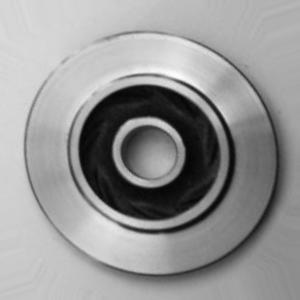

In [6]:
import random
from PIL import Image
random.seed()
image_path_list = list(image_path.glob("*/*/*.jpeg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem #here we're essentially using the name of the folder to define the image class
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

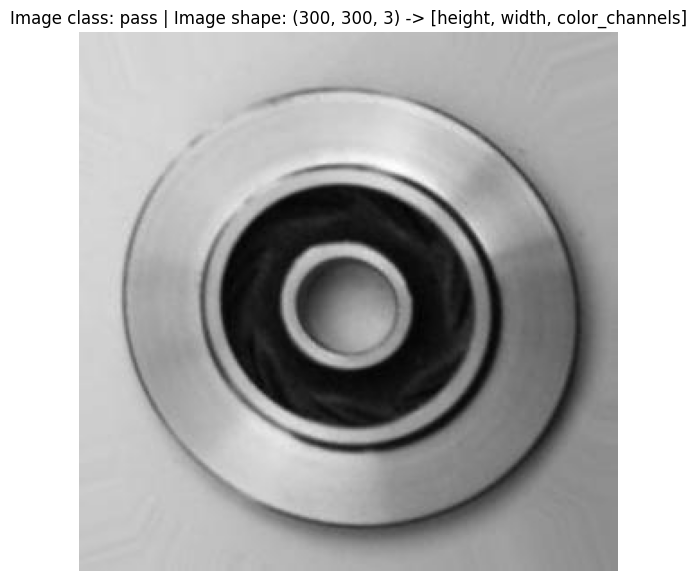

In [7]:
#visualization using matplotlib

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [180]:
#convert to greyscale
from torchvision.transforms.functional import rgb_to_grayscale

train_dir

WindowsPath('data/casting_data/train')

# Transforming Our images

In [233]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2

data_transform = v2.Compose([
                v2.Resize(size=(224, 224)),
                v2.ToTensor()])

#original
train_data_transform = v2.Compose([
                v2.Resize(size=(224, 224)),
                v2.RandomHorizontalFlip(p = 0.5),
                v2.ColorJitter(brightness = (0.7, 1.3), contrast = (0.7, 1.3), saturation = (0.7, 1.3), hue = (-0.3, 0.3)),
                v2.RandomVerticalFlip(p = 0.5),
                #v2.Grayscale(num_output_channels= 1),
                v2.ToTensor()])

#new
train_data_transform2 = v2.Compose([
                v2.Resize(size=(224, 224)),
                v2.RandomHorizontalFlip(p = 0.3),
                v2.ColorJitter(brightness = (0.7, 1.3), contrast = (0.7, 1.3), saturation = (0.7,1.3), hue = (-0.3, 0.3)),
                v2.RandomInvert(p = 0.05),
                v2.RandomAdjustSharpness(3, p = 0.05),
                v2.RandomVerticalFlip(p = 0.3),
                v2.ToTensor()])

test_data_transform = v2.Compose([
                v2.Resize(size=(224, 224)),
                #v2.Grayscale(num_output_channels= 1),
                v2.ToTensor()])



#print(data_transform(img))
print(data_transform(img).shape)
print(data_transform(img).dtype)

#print(train_data_transform(img))
print(train_data_transform(img).shape)
print(train_data_transform(img).dtype)

#print(test_data_transform(img))
print(test_data_transform(img).shape)
print(test_data_transform(img).dtype)


c:\Users\Nebula PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([3, 224, 224])
torch.float32
torch.Size([3, 224, 224])
torch.float32
torch.Size([3, 224, 224])
torch.float32


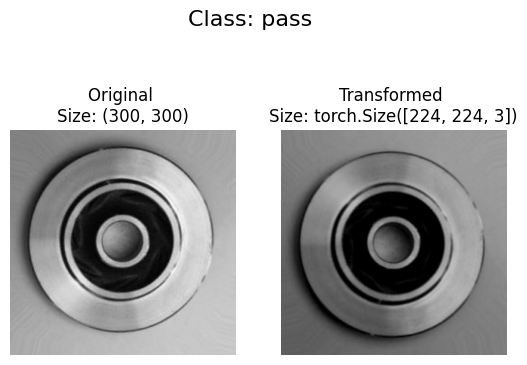

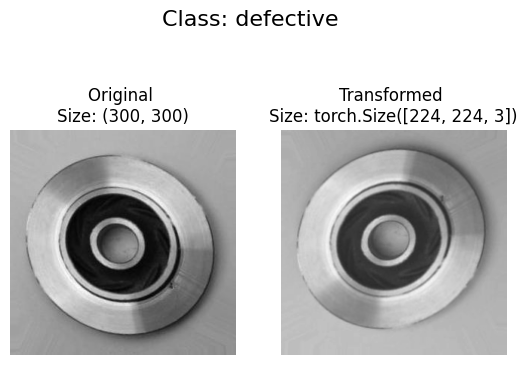

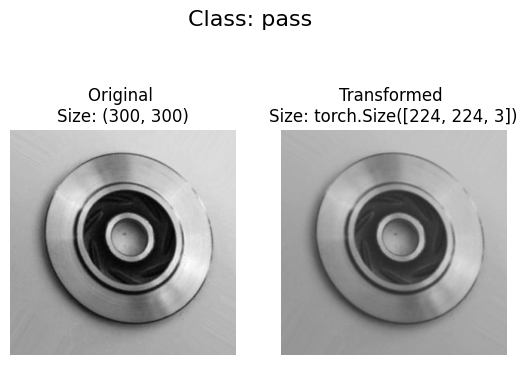

In [234]:
def plot_transformed_images(image_paths, transform, n = 5, seed = None):
    """Plots a series of random images from image_paths.
    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.
    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n) #taking a random sample from image_paths, k = n images
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows = 1, ncols = 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            # Transform and plot images, Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)



plot_transformed_images(image_path_list, 
                        transform=train_data_transform, 
                        n=3)

In [235]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=train_data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_data_transform)


train_data333 = datasets.ImageFolder(root=train_dir, transform=data_transform)

image, label = train_data[0]
image, label

train_data

#train_data333

Dataset ImageFolder
    Number of datapoints: 6633
    Root location: data\casting_data\train
    StandardTransform
Transform: Compose(
                 Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.3, 0.3))
                 RandomVerticalFlip(p=0.5)
                 ToTensor()
           )

In [236]:
print(image.shape) #dimensions are color channels, height and width
print(label)

#info in train data
print(train_data.classes)
print(train_data.targets)

torch.Size([3, 224, 224])
0
['defective', 'pass']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [237]:
print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 6633
    Root location: data\casting_data\train
    StandardTransform
Transform: Compose(
                 Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.3, 0.3))
                 RandomVerticalFlip(p=0.5)
                 ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 715
    Root location: data\casting_data\test
    StandardTransform
Transform: Compose(
                 Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToTensor()
           )


In [238]:
#getting attributes of the data (can see the attributes in the popup when coding)
class_names = train_data.classes
class_dict = train_data.class_to_idx #target values of classes

In [371]:
BATCH_SIZE = 32
NUM_WORKERS = 0


print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")
# Create DataLoader's
random.seed(42)
#train_dataloader = DataLoader(train_data, 
     #                       batch_size=BATCH_SIZE, 
               #             shuffle=True, 
                #            num_workers=NUM_WORKERS)
random.seed(42)
test_dataloader = DataLoader(test_data, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False, 
                            num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 0 workers.


(<torch.utils.data.dataloader.DataLoader at 0x286ceccaa20>,
 <torch.utils.data.dataloader.DataLoader at 0x286c8914590>)

In [278]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels=64, kernel_size=3, stride=1, padding=2),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(p = 0.05),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels = 64, out_channels= 64, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(p = 0.05),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels = 128, out_channels=128, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels = 128, out_channels=64, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(p = 0.05),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.AdaptiveAvgPool2d(output_size =(14, 14))
            nn.Flatten(),
            nn.Linear(in_features=64*7*7, out_features=32*7*7),
            #nn.BatchNorm2d(32*7*7),
            nn.Linear(in_features=32*7*7, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor):
        return self.block1(x)

In [257]:
model_0 = CNN().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0005)#, weight_decay = 1e-4)

from torcheval.metrics.functional.classification import binary_recall 
from torcheval.metrics.functional.classification import binary_precision
from torcheval.metrics.functional.classification import binary_f1_score
from torcheval.metrics.functional.classification import binary_auroc

In [376]:
def train_step_binary(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    random.seed(42)
    train_dataloader = DataLoader(train_data, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True, 
                            num_workers=NUM_WORKERS)

    model.train()
    train_loss, train_acc, train_recall, train_precision, train_f1 = 0, 0, 0, 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        train_pred = model(X).squeeze()  # Remove the extra dimension
        loss = loss_fn(train_pred, y.float())  # Ensure y is of float type 
        train_loss += loss.item() # total loss over all batches
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()      
        train_pred_binary = torch.round(train_pred)
        train_acc += (train_pred_binary == y).sum().item()/len(train_pred_binary)
        train_recall += binary_recall(train_pred_binary, y).item()
        train_precision += binary_precision(train_pred_binary, y).item()
        train_f1 += binary_f1_score(train_pred_binary, y).item()
        avg_train_recall = train_recall / (batch + 1)
        avg_train_precision = train_precision / (batch + 1)
        avg_train_loss = train_loss / (batch + 1)
        if batch % 1 == 0 and batch > 0:
            print(f"Training Batch {batch}/{len(dataloader)} | Training Loss: {avg_train_loss}")
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    train_recall = train_recall / len(dataloader)
    train_precision = train_precision / len(dataloader)
    train_f1 = train_f1 / len(dataloader)
    return train_loss, train_acc, train_recall, train_precision, train_f1

In [332]:
model_0.train()
train_loss, train_acc, train_recall, train_precision, train_f1 = 0, 0, 0, 0, 0
for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    train_pred = model_0(X).squeeze()  # Remove the extra dimension
    loss = loss_fn(train_pred, y.float())  # Ensure y is of float type 
    train_loss += loss.item() # total loss over all batches
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()      
    train_pred_binary = torch.round(train_pred)
    train_acc += (train_pred_binary == y).sum().item()/len(train_pred_binary)
    train_recall += binary_recall(train_pred_binary, y).item()
    print(train_pred_binary)
    print(y)

tensor([1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
        0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       device='cuda:0', grad_fn=<RoundBackward0>)
tensor([1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.],
       device='cuda:0', grad_fn=<RoundBackward0>)
tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
tensor([1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<RoundBackward0>)
tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
tensor([1., 1., 0., 0., 0

KeyboardInterrupt: 

In [342]:
def test_step_binary(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    test_loss, test_acc, test_recall, test_precision, test_f1 = 0, 0, 0, 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y = y.to(torch.float32)
            test_pred = model(X).squeeze()
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_pred_binary = torch.round(test_pred)
            test_acc += (test_pred_binary == y).sum().item()/len(test_pred_binary)
            #test_recall += binary_recall(test_pred_binary, y).item()
            #test_precision += binary_precision(test_pred_binary, y).item()
            test_f1 += binary_f1_score(test_pred_binary, y).item()
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    #test_recall = test_recall / len(dataloader)
    #test_precision = test_precision / len(dataloader)
    test_f1 = test_f1 / len(dataloader)
    return test_loss, test_acc, test_recall, test_precision, test_f1

In [338]:
model_0.eval() 
test_loss, test_acc, test_recall, test_precision, test_f1 = 0, 0, 0, 0, 0
with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.to(device)
        y = y.to(torch.float32)
        test_pred = model_0(X).squeeze()
        loss = loss_fn(test_pred, y)
        test_loss += loss.item()
        test_pred_binary = torch.round(test_pred)
        test_acc += (test_pred_binary == y).sum().item()/len(test_pred_binary)
        test_recall += binary_recall(test_pred_binary, y).item()
        #test_precision += binary_precision(test_pred_binary, y).item()
        test_f1 += binary_f1_score(test_pred_binary, y).item()
        #print(f"test bin{test_pred_binary.shape}")
        print(f"y {y}")
        print(test_f1)
        

RuntimeError: "bitwise_and_cuda" not implemented for 'Float'

In [377]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int):


    # 2. Create empty results dictionary
    #results = {"train_loss": [],
    #    "train_acc": [],
    #    "test_loss": [],
    #    "test_acc": [],
    #}
    from tqdm.auto import tqdm
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        print(f"\n|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH {epoch + 1} |-|-|-|-|-|-|-|-|-|-|-|-|-|\n")
        train_dataloader = DataLoader(train_data, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True, 
                            num_workers=NUM_WORKERS)
        
        train_loss, train_acc, train_recall, train_precision, train_f1 = train_step_binary(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        test_loss, test_acc, test_recall, test_precision, test_f1 = test_step_binary(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH {epoch+1} FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|\n\n"
            f"train loss: {train_loss:.4f}   |   "
            f"train acc: {train_acc:.4f}   |   "
         #   f"train precision: {train_precision:.4f} | "
         #   f"train recall: {train_recall:.4f} | "
            f"train f1: {train_f1:.4f}\n"
            f"test loss: {test_loss:.4f}   |   "
            f"test acc: {test_acc:.4f}   |   "
         #   f"test precision: {test_precision:.4f} | "
          #  f"test recall: {test_recall:.4f} | "
            f"test f1: {test_f1:.4f}\n\n\n"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["train_recall"].append(train_recall)
        results["train_precision"].append(train_precision)
        results["train_f1"].append(train_f1)
        #results["test_recall"].append(test_recall)
        #results["test_precision"].append(test_precision)
        results["test_f1"].append(test_f1)

    # 6. Return the filled results at the end of the epochs
    return results

In [378]:
model_0 = CNN().to(device)
loss_fn = nn.BCELoss()

results = {"train_loss": [],
        "train_acc": [],
        "train_recall":[],
        "train_precision":[],
        "train_f1":[],
        "test_loss": [],
        "test_acc": [],
  #      "test_recall":[],
 #       "test_precision":[],
        "test_f1":[],

}

In [391]:
from timeit import default_timer as timer 
torch.manual_seed(42) 
torch.cuda.manual_seed(42)


NUM_EPOCHS = 15
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.00005)
start_time = timer()

model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 1 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.06249044183641672
Training Batch 2/208 | Training Loss: 0.047341944028933845
Training Batch 3/208 | Training Loss: 0.050634280778467655
Training Batch 4/208 | Training Loss: 0.04364212974905968
Training Batch 5/208 | Training Loss: 0.050268285597364105
Training Batch 6/208 | Training Loss: 0.045332188851067
Training Batch 7/208 | Training Loss: 0.047576435608789325
Training Batch 8/208 | Training Loss: 0.04596532281074259
Training Batch 9/208 | Training Loss: 0.048100542090833184
Training Batch 10/208 | Training Loss: 0.04452244327826933
Training Batch 11/208 | Training Loss: 0.0451781532416741
Training Batch 12/208 | Training Loss: 0.044529167505411
Training Batch 13/208 | Training Loss: 0.043122059133435996
Training Batch 14/208 | Training Loss: 0.05826799434920152
Training Batch 15/208 | Training Loss: 0.05819479434285313
Training Batch 16/208 | Training Loss: 0.058381

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 1 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0670   |   train acc: 0.9784   |   train f1: 0.9739
test loss: 0.0368   |   test acc: 0.9891   |   test f1: 0.3885





  7%|▋         | 1/15 [01:46<24:53, 106.68s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 2 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.03681820444762707
Training Batch 2/208 | Training Loss: 0.11577273284395535
Training Batch 3/208 | Training Loss: 0.09972326923161745
Training Batch 4/208 | Training Loss: 0.08191277980804443
Training Batch 5/208 | Training Loss: 0.07472132643063863
Training Batch 6/208 | Training Loss: 0.07227916749460357
Training Batch 7/208 | Training Loss: 0.068008987698704
Training Batch 8/208 | Training Loss: 0.0625630317048894
Training Batch 9/208 | Training Loss: 0.0595760440453887
Training Batch 10/208 | Training Loss: 0.05665667151862925
Training Batch 11/208 | Training Loss: 0.057810939848423004
Training Batch 12/208 | Training Loss: 0.05572630995168136
Training Batch 13/208 | Training Loss: 0.05700087720262153
Training Batch 14/208 | Training Loss: 0.05627549327909946
Training Batch 15/208 | Training Loss: 0.05476993147749454
Training Batch 16/208 | Training Loss: 0.0569725931

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 2 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0596   |   train acc: 0.9803   |   train f1: 0.9770
test loss: 0.0383   |   test acc: 0.9864   |   test f1: 0.3885





 13%|█▎        | 2/15 [03:48<25:04, 115.74s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 3 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.18749036639928818
Training Batch 2/208 | Training Loss: 0.14197070275743803
Training Batch 3/208 | Training Loss: 0.12773397658020258
Training Batch 4/208 | Training Loss: 0.10919832736253739
Training Batch 5/208 | Training Loss: 0.13913702592253685
Training Batch 6/208 | Training Loss: 0.16087117471865245
Training Batch 7/208 | Training Loss: 0.14722699578851461
Training Batch 8/208 | Training Loss: 0.13781724373499551
Training Batch 9/208 | Training Loss: 0.12691554352641105
Training Batch 10/208 | Training Loss: 0.12335148385979912
Training Batch 11/208 | Training Loss: 0.11593294516205788
Training Batch 12/208 | Training Loss: 0.12098374733558068
Training Batch 13/208 | Training Loss: 0.11732987208025795
Training Batch 14/208 | Training Loss: 0.11028355633219084
Training Batch 15/208 | Training Loss: 0.10676496522501111
Training Batch 16/208 | Training Loss: 0.1016885

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 3 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0657   |   train acc: 0.9802   |   train f1: 0.9759
test loss: 0.0376   |   test acc: 0.9851   |   test f1: 0.3885





 20%|██        | 3/15 [05:40<22:45, 113.82s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 4 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.043196024838835
Training Batch 2/208 | Training Loss: 0.04567824707676967
Training Batch 3/208 | Training Loss: 0.05807346780784428
Training Batch 4/208 | Training Loss: 0.05045122336596251
Training Batch 5/208 | Training Loss: 0.047695756424218416
Training Batch 6/208 | Training Loss: 0.04794893879443407
Training Batch 7/208 | Training Loss: 0.04460191389080137
Training Batch 8/208 | Training Loss: 0.04266149478240146
Training Batch 9/208 | Training Loss: 0.040923941414803267
Training Batch 10/208 | Training Loss: 0.04228671394627203
Training Batch 11/208 | Training Loss: 0.04265637253411114
Training Batch 12/208 | Training Loss: 0.04176925975256241
Training Batch 13/208 | Training Loss: 0.04137554332347853
Training Batch 14/208 | Training Loss: 0.040989463962614534
Training Batch 15/208 | Training Loss: 0.03967514639953151
Training Batch 16/208 | Training Loss: 0.039529

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 4 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0589   |   train acc: 0.9823   |   train f1: 0.9790
test loss: 0.0442   |   test acc: 0.9823   |   test f1: 0.3885





 27%|██▋       | 4/15 [07:44<21:35, 117.74s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 5 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.033589744940400124
Training Batch 2/208 | Training Loss: 0.04054241254925728
Training Batch 3/208 | Training Loss: 0.035093261394649744
Training Batch 4/208 | Training Loss: 0.04181944616138935
Training Batch 5/208 | Training Loss: 0.03586653177626431
Training Batch 6/208 | Training Loss: 0.06388705802549209
Training Batch 7/208 | Training Loss: 0.059045660484116524
Training Batch 8/208 | Training Loss: 0.06309748456502955
Training Batch 9/208 | Training Loss: 0.05935887112282216
Training Batch 10/208 | Training Loss: 0.05475840273059227
Training Batch 11/208 | Training Loss: 0.05094188688478122
Training Batch 12/208 | Training Loss: 0.04807856517772262
Training Batch 13/208 | Training Loss: 0.05388825982143836
Training Batch 14/208 | Training Loss: 0.05093722967430949
Training Batch 15/208 | Training Loss: 0.04949446933460422
Training Batch 16/208 | Training Loss: 0.0491

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 5 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0596   |   train acc: 0.9826   |   train f1: 0.9791
test loss: 0.0393   |   test acc: 0.9837   |   test f1: 0.3878





 33%|███▎      | 5/15 [09:29<18:51, 113.17s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 6 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.07126284390687943
Training Batch 2/208 | Training Loss: 0.055812048415342964
Training Batch 3/208 | Training Loss: 0.046443022321909666
Training Batch 4/208 | Training Loss: 0.05017717145383358
Training Batch 5/208 | Training Loss: 0.04674765126158794
Training Batch 6/208 | Training Loss: 0.047995430284312794
Training Batch 7/208 | Training Loss: 0.04596761125139892
Training Batch 8/208 | Training Loss: 0.04686602018773556
Training Batch 9/208 | Training Loss: 0.0578053092584014
Training Batch 10/208 | Training Loss: 0.0641248556361957
Training Batch 11/208 | Training Loss: 0.06418474499757092
Training Batch 12/208 | Training Loss: 0.061920626948659234
Training Batch 13/208 | Training Loss: 0.08408776577562094
Training Batch 14/208 | Training Loss: 0.08049193310240904
Training Batch 15/208 | Training Loss: 0.07748720713425428
Training Batch 16/208 | Training Loss: 0.07400

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 6 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0643   |   train acc: 0.9794   |   train f1: 0.9754
test loss: 0.0383   |   test acc: 0.9851   |   test f1: 0.3899





 40%|████      | 6/15 [11:33<17:33, 117.04s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 7 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.07296764850616455
Training Batch 2/208 | Training Loss: 0.056022451569636665
Training Batch 3/208 | Training Loss: 0.05130746215581894
Training Batch 4/208 | Training Loss: 0.05605488270521164
Training Batch 5/208 | Training Loss: 0.05719363192717234
Training Batch 6/208 | Training Loss: 0.05044437000261886
Training Batch 7/208 | Training Loss: 0.07625054300297052
Training Batch 8/208 | Training Loss: 0.07571447568221225
Training Batch 9/208 | Training Loss: 0.06921808114275337
Training Batch 10/208 | Training Loss: 0.07145709061825817
Training Batch 11/208 | Training Loss: 0.06718559881361823
Training Batch 12/208 | Training Loss: 0.06507826431726034
Training Batch 13/208 | Training Loss: 0.06444208437044706
Training Batch 14/208 | Training Loss: 0.06340420401344697
Training Batch 15/208 | Training Loss: 0.07019712548935786
Training Batch 16/208 | Training Loss: 0.069098

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 7 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0638   |   train acc: 0.9808   |   train f1: 0.9774
test loss: 0.0362   |   test acc: 0.9891   |   test f1: 0.3870





 47%|████▋     | 7/15 [13:27<15:27, 115.88s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 8 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.10904407408088446
Training Batch 2/208 | Training Loss: 0.11752410667637984
Training Batch 3/208 | Training Loss: 0.12005309714004397
Training Batch 4/208 | Training Loss: 0.13504500053822993
Training Batch 5/208 | Training Loss: 0.12137862760573626
Training Batch 6/208 | Training Loss: 0.12276931080435004
Training Batch 7/208 | Training Loss: 0.10955259040929377
Training Batch 8/208 | Training Loss: 0.10027067963447836
Training Batch 9/208 | Training Loss: 0.0963859612122178
Training Batch 10/208 | Training Loss: 0.09100143154236404
Training Batch 11/208 | Training Loss: 0.08627495526646574
Training Batch 12/208 | Training Loss: 0.08304700040473388
Training Batch 13/208 | Training Loss: 0.0851666321977973
Training Batch 14/208 | Training Loss: 0.08271233501533667
Training Batch 15/208 | Training Loss: 0.07933129486627877
Training Batch 16/208 | Training Loss: 0.075874718

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 8 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0629   |   train acc: 0.9815   |   train f1: 0.9782
test loss: 0.0347   |   test acc: 0.9878   |   test f1: 0.3870





 53%|█████▎    | 8/15 [15:27<13:40, 117.17s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 9 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.03059544786810875
Training Batch 2/208 | Training Loss: 0.0242891867334644
Training Batch 3/208 | Training Loss: 0.029964994406327605
Training Batch 4/208 | Training Loss: 0.025944497250020505
Training Batch 5/208 | Training Loss: 0.02479115330303709
Training Batch 6/208 | Training Loss: 0.029647926799952984
Training Batch 7/208 | Training Loss: 0.03424681315664202
Training Batch 8/208 | Training Loss: 0.06107647189249595
Training Batch 9/208 | Training Loss: 0.0562099140137434
Training Batch 10/208 | Training Loss: 0.05467817830768498
Training Batch 11/208 | Training Loss: 0.0553143173456192
Training Batch 12/208 | Training Loss: 0.06132979461779961
Training Batch 13/208 | Training Loss: 0.05912766685443265
Training Batch 14/208 | Training Loss: 0.061200904597838716
Training Batch 15/208 | Training Loss: 0.05905355338472873
Training Batch 16/208 | Training Loss: 0.056018

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 9 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0574   |   train acc: 0.9820   |   train f1: 0.9786
test loss: 0.0343   |   test acc: 0.9891   |   test f1: 0.3899





 60%|██████    | 9/15 [17:20<11:36, 116.05s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 10 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.1314198593609035
Training Batch 2/208 | Training Loss: 0.13325888384133577
Training Batch 3/208 | Training Loss: 0.1041764144320041
Training Batch 4/208 | Training Loss: 0.09332707468420268
Training Batch 5/208 | Training Loss: 0.09014228809004028
Training Batch 6/208 | Training Loss: 0.08512481581419706
Training Batch 7/208 | Training Loss: 0.0778209367999807
Training Batch 8/208 | Training Loss: 0.07794485044562155
Training Batch 9/208 | Training Loss: 0.07303734784945845
Training Batch 10/208 | Training Loss: 0.0692977128889073
Training Batch 11/208 | Training Loss: 0.08558388388094802
Training Batch 12/208 | Training Loss: 0.08043237567807619
Training Batch 13/208 | Training Loss: 0.0780351589699941
Training Batch 14/208 | Training Loss: 0.07607098414252202
Training Batch 15/208 | Training Loss: 0.07273958314908668
Training Batch 16/208 | Training Loss: 0.06967774762

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 10 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0556   |   train acc: 0.9845   |   train f1: 0.9818
test loss: 0.0289   |   test acc: 0.9878   |   test f1: 0.3885





 67%|██████▋   | 10/15 [19:21<09:47, 117.57s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 11 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.05484826676547527
Training Batch 2/208 | Training Loss: 0.04364300146698952
Training Batch 3/208 | Training Loss: 0.04670259356498718
Training Batch 4/208 | Training Loss: 0.03956193216145039
Training Batch 5/208 | Training Loss: 0.03518172136197487
Training Batch 6/208 | Training Loss: 0.030985830019095113
Training Batch 7/208 | Training Loss: 0.02988434088183567
Training Batch 8/208 | Training Loss: 0.027570558556665976
Training Batch 9/208 | Training Loss: 0.025497266417369248
Training Batch 10/208 | Training Loss: 0.027662651232359083
Training Batch 11/208 | Training Loss: 0.02755320176947862
Training Batch 12/208 | Training Loss: 0.026645393003351413
Training Batch 13/208 | Training Loss: 0.02525213044801993
Training Batch 14/208 | Training Loss: 0.032209432156135635
Training Batch 15/208 | Training Loss: 0.03053955500945449
Training Batch 16/208 | Training Loss: 0.

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 11 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0581   |   train acc: 0.9827   |   train f1: 0.9796
test loss: 0.0320   |   test acc: 0.9878   |   test f1: 0.3892





 73%|███████▎  | 11/15 [21:10<07:39, 114.93s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 12 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.04311179043725133
Training Batch 2/208 | Training Loss: 0.0382171810294191
Training Batch 3/208 | Training Loss: 0.06526744668371975
Training Batch 4/208 | Training Loss: 0.06406058240681886
Training Batch 5/208 | Training Loss: 0.058782202657312155
Training Batch 6/208 | Training Loss: 0.053371316753327847
Training Batch 7/208 | Training Loss: 0.05875337135512382
Training Batch 8/208 | Training Loss: 0.05586188296890921
Training Batch 9/208 | Training Loss: 0.0512599472887814
Training Batch 10/208 | Training Loss: 0.04798807136037133
Training Batch 11/208 | Training Loss: 0.04774019494652748
Training Batch 12/208 | Training Loss: 0.044899920718027994
Training Batch 13/208 | Training Loss: 0.044328232162765095
Training Batch 14/208 | Training Loss: 0.04699047779043516
Training Batch 15/208 | Training Loss: 0.046152215683832765
Training Batch 16/208 | Training Loss: 0.044

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 12 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0528   |   train acc: 0.9824   |   train f1: 0.9789
test loss: 0.0443   |   test acc: 0.9796   |   test f1: 0.3899





 80%|████████  | 12/15 [23:16<05:54, 118.12s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 13 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.07327425945550203
Training Batch 2/208 | Training Loss: 0.05858905427157879
Training Batch 3/208 | Training Loss: 0.046077452134341
Training Batch 4/208 | Training Loss: 0.039972396194934846
Training Batch 5/208 | Training Loss: 0.041481539607048035
Training Batch 6/208 | Training Loss: 0.04967469722032547
Training Batch 7/208 | Training Loss: 0.045683495700359344
Training Batch 8/208 | Training Loss: 0.04399949871003628
Training Batch 9/208 | Training Loss: 0.040226283762603995
Training Batch 10/208 | Training Loss: 0.03702667482535948
Training Batch 11/208 | Training Loss: 0.03519066648247341
Training Batch 12/208 | Training Loss: 0.0350211552845744
Training Batch 13/208 | Training Loss: 0.03627516362550003
Training Batch 14/208 | Training Loss: 0.037462298882504304
Training Batch 15/208 | Training Loss: 0.047053336922544986
Training Batch 16/208 | Training Loss: 0.054

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 13 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0519   |   train acc: 0.9823   |   train f1: 0.9786
test loss: 0.0276   |   test acc: 0.9905   |   test f1: 0.3884





 87%|████████▋ | 13/15 [25:03<03:49, 114.87s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 14 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.0303520355373621
Training Batch 2/208 | Training Loss: 0.028281139209866524
Training Batch 3/208 | Training Loss: 0.03433073731139302
Training Batch 4/208 | Training Loss: 0.02945783231407404
Training Batch 5/208 | Training Loss: 0.04081057834749421
Training Batch 6/208 | Training Loss: 0.03955131143863712
Training Batch 7/208 | Training Loss: 0.06112358730752021
Training Batch 8/208 | Training Loss: 0.06171592086967495
Training Batch 9/208 | Training Loss: 0.0566805487498641
Training Batch 10/208 | Training Loss: 0.05309280211275274
Training Batch 11/208 | Training Loss: 0.050992353819310665
Training Batch 12/208 | Training Loss: 0.06056827220779199
Training Batch 13/208 | Training Loss: 0.05702385811933449
Training Batch 14/208 | Training Loss: 0.06786884640653928
Training Batch 15/208 | Training Loss: 0.064065023267176
Training Batch 16/208 | Training Loss: 0.06115342

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 14 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0514   |   train acc: 0.9832   |   train f1: 0.9798
test loss: 0.0287   |   test acc: 0.9891   |   test f1: 0.3877





 93%|█████████▎| 14/15 [27:02<01:56, 116.17s/it]


|-|-|-|-|-|-|-|-|-|-|-|-|-| BEGINNING EPOCH 15 |-|-|-|-|-|-|-|-|-|-|-|-|-|

Training Batch 1/208 | Training Loss: 0.1286009233444929
Training Batch 2/208 | Training Loss: 0.09627962484955788
Training Batch 3/208 | Training Loss: 0.09854601975530386
Training Batch 4/208 | Training Loss: 0.08641487136483192
Training Batch 5/208 | Training Loss: 0.07495946219811837
Training Batch 6/208 | Training Loss: 0.06557208113372326
Training Batch 7/208 | Training Loss: 0.05932708573527634
Training Batch 8/208 | Training Loss: 0.058063818555739194
Training Batch 9/208 | Training Loss: 0.0724255682900548
Training Batch 10/208 | Training Loss: 0.06637865330346605
Training Batch 11/208 | Training Loss: 0.06152247707359493
Training Batch 12/208 | Training Loss: 0.05915769526305107
Training Batch 13/208 | Training Loss: 0.05581062480009028
Training Batch 14/208 | Training Loss: 0.0731262831017375
Training Batch 15/208 | Training Loss: 0.08242727239849046
Training Batch 16/208 | Training Loss: 0.08071841

|-|-|-|-|-|-|-|-|-|-|-|-|-| EPOCH 15 FINISHED |-|-|-|-|-|-|-|-|-|-|-|-|-|

train loss: 0.0537   |   train acc: 0.9835   |   train f1: 0.9802
test loss: 0.0249   |   test acc: 0.9918   |   test f1: 0.3885





100%|██████████| 15/15 [28:47<00:00, 115.18s/it]


Total training time: 1727.729 seconds


In [1]:
import pandas as pd
pd.DataFrame(results)

NameError: name 'results' is not defined

In [387]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [2]:
plot_loss_curves(model_0_results)

NameError: name 'plot_loss_curves' is not defined

In [369]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_0.eval()
with torch.inference_mode():
  for batch, (X, y) in enumerate(test_dataloader):
      # Send data and targets to target device
      X, y = X.to(device), y.to(device)
      # Do the forward pass
      y_val = model_0(X)
      # Turn predictions from logits -> prediction probabilities -> predictions labels
      y_pred = torch.round(y_val) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
      # Put predictions on CPU for evaluation
      y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

BinaryConfusionMatrix()

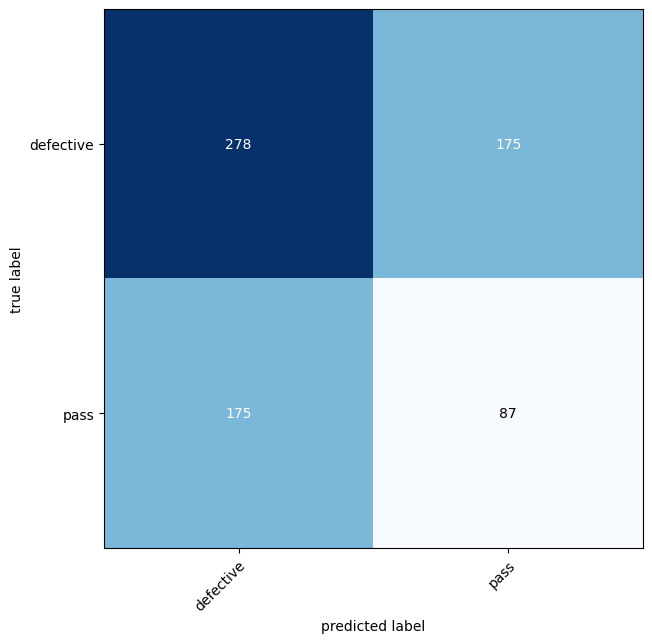

In [370]:
test_targets = torch.Tensor(test_data.targets)

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='binary')
confmat_tensor = confmat(preds=y_pred_tensor.squeeze(),
                         target=test_targets)

#3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [139]:
misclassified_images = []

# Evaluation loop
model_0.eval()
for images, labels in test_dataloader:
    with torch.no_grad():
        outputs = model_0(images)
        _, predicted = torch.round(outputs, 1)
    
    # Collect misclassified images
    for i in range(len(labels)):
        if predicted[i] != labels[i]:
            misclassified_images.append((images[i], predicted[i], labels[i]))

# Visualize misclassified images
#for image, predicted_label, true_label in misclassified_images:

AttributeError: 'DataLoader' object has no attribute 'to'

In [145]:
import torch

# Move model to device
model_0.to(device)

misclassified_images = []

# Evaluation loop
model_0.eval()
for images, labels in test_dataloader:
    with torch.no_grad():
        # Move input tensor to device
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model_0(images)
        predicted = torch.round(outputs)  # Move predictions to CPU for comparison
    
    # Collect misclassified images
    for i in range(len(labels)):
        if predicted[i] != labels[i]:
            misclassified_images.append((images[i], predicted[i], labels[i]))

# Visualize misclassified images
for image, predicted_label, true_label in misclassified_images:
    # Display the image
    imshow(image)  # Move image to CPU for visualization
    # Print predicted and true labels
    print(f'Predicted label: {predicted_label}, True label: {true_label}')

TypeError: 'module' object is not callable

In [152]:
misclassified_images_tensor = torch.Tensor(misclassified_images)

ValueError: only one element tensors can be converted to Python scalars

In [181]:
misclassified_images[][0][0].shape

torch.Size([224, 224])

In [182]:
from torchvision.utils import make_grid

In [183]:
model_0.to(device)

misclassified_images = []

# Evaluation loop
model_0.eval()
for images, labels in test_dataloader:
    with torch.no_grad():
        # Move input tensor to device
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model_0(images)
        binary_outputs = torch.round(outputs)

In [188]:
test_dataloader

In [190]:
y_pred_tensor.shape

torch.Size([715, 1])

In [203]:
confmat_np = confmat_tensor.numpy()

# Initialize a list to store misclassified image indices
misclassified_indices = []

# Loop through the confusion matrix to identify misclassified images
for i in range(len(confmat_np)):
    for j in range(len(confmat_np)):
        if i != j and confmat_np[i, j] > 0:
            # i is the true label, j is the predicted label
            # Append the indices of misclassified images to the list
            misclassified_indices.extend(torch.nonzero((test_targets == i) & (y_pred_tensor == j)).squeeze())

## Remove duplicate indices
misclassified_indices = set(misclassified_indices)

# Now you have the indices of misclassified images
# You can retrieve the misclassified images from your dataset
misclassified_images = [test_data[index] for index in misclassified_indices]

# Visualize or process the misclassified images as needed

TypeError: only integer tensors of a single element can be converted to an index

In [206]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

def invalid_predictions(n=10, images = images, labels = labels):
    invalid_ids = []
    image_count = 0
    invalid_count = 0
    while invalid_count < n:
        prediction = predict_image(images[image_count], model)
        if prediction != labels[image_count ]:
            invalid_ids.append(image_count )
            invalid_count +=1
        image_count += 1
    return invalid_ids

In [207]:
invalid_predictions(n = 10, images = images, labels = labels)

NameError: name 'predict_image' is not defined

In [227]:
incorrect_examples = []
incorrect_labels = []
incorrect_pred = []
model_0.eval()
for batch, (X, y) in enumerate(test_dataloader):

  X, y = X.to(device), y.to(device)
  output = model_0(X).squeeze() # shape = torch.Size([batch_size, 10])
  #pred = torch.round(output)#pred will be a 2d tensor of shape [batch_size,1]
  #idxs_mask = ((pred == target.view_as(pred))==False).view(-1)
  #if idxs_mask.numel(): #if index masks is non-empty append the correspoding data value in incorrect examples
  #  incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy())
  #  incorrect_labels.append(target[idxs_mask].cpu().numpy()) #the corresponding target to the misclassified image
    #incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy()) #the corresponiding predicted class of the misclassified image

In [221]:
incorrect_examples[:][3]

array([], shape=(0, 3, 224, 224), dtype=float32)

In [229]:
output

tensor([0.9902, 0.9986, 0.9999, 0.9603, 0.9939, 0.9726, 0.9935, 0.9989, 0.9964,
        0.9987, 0.9876], device='cuda:0', grad_fn=<SqueezeBackward0>)

# Attempting to use a pretrained model

In [216]:
pip install torcheval


  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/179.2 kB ? eta -:--:--
   --------- ------------------------------ 41.0/179.2 kB 1.9 MB/s eta 0:00:01
   -------------------------------------- - 174.1/179.2 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 179.2/179.2 kB 1.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [264]:
from pretrainedmodels import xception
import torch
from torcheval.metrics.functional import binary_f1_score
from torchvision.models import vgg16, VGG16_Weights

In [266]:
vgg16_model = vgg16(VGG16_Weights.IMAGENET1K_V1)

for param in vgg16_model.parameters():
    param.requires_grad = False

num_features = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = torch.nn.Linear(num_features, 1)  

# Optionally, move the model to a GPU device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_model = vgg16_model.to(device)

# Now, you can use the modified VGG16 model for your specific task

In [259]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
vgg16_model = vgg16_model.to(device)
results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
}

In [267]:
NUM_EPOCHS = 1
start_time = timer()
vgg16_model_results = train(model=vgg16_model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/1 [01:17<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [238]:
class ConvBnRelu2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size = 3, padding= 1),
                                  nn.BatchNorm2d(4),
                                  nn.ReLU(inplace=True)
                                  )

    def forward(self, x):
        return self.conv(x)


class Xception(nn.Module):
    def __init__(self, num_classes=1, pretrained='imagenet', dropout_rate=0.):
        super(Xception, self).__init__()
        self.pretrained_model = xception(pretrained=pretrained)
        self.process_input = nn.Sequential(
            ConvBnRelu2d(3, 16),
            ConvBnRelu2d(16, 3),
        )
        self.fc_input = 2048
        self.activation = nn.ReLU()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.last_linear = nn.Linear(self.fc_input, num_classes)

    def forward(self, x):
        x = self.process_input(x)
        x = self.pretrained_model.features(x)
        x = self.activation(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.last_linear(x)
        x = nn.Sigmoid(x)
        return x

In [239]:
model = Xception(num_classes=1, pretrained= None).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
}

In [240]:
from timeit import default_timer as timer 
torch.manual_seed(42) 
torch.cuda.manual_seed(42)


NUM_EPOCHS = 15
start_time = timer()
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:50<?, ?it/s]


RuntimeError: Given groups=1, weight of size [4, 3, 3, 3], expected input[32, 4, 224, 224] to have 3 channels, but got 4 channels instead

In [ ]:
def f1_loss(target, output, epsilon=1e-7):
    y_pred = nn.Sigmoid()(output)
    y_true = target.double()

    TP = (y_pred * y_true).sum(1)
    prec = TP / (y_pred.sum(1) + epsilon)
    rec = TP / (y_true.sum(1) + epsilon)
    res = 2 * prec * rec / (prec + rec + epsilon)

    f1 = res
    f1 = f1.clamp(min=0)
    return 1 - f1.mean()


from sklearn.metrics import f1_score

sk_f1_score = f1_score


class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def init(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __repr__(self):
        return str(self.avg)

In [ ]:
EPOCHS, BATCH_SIZE, BASE_LR, DEVICE

In [ ]:
model = Xception(num_classes=2, pretrained='imagenet').to(device)


gtrain = MultiBandMultiLabelDataset(df_train, base_path=PATH_TO_IMAGES, image_transform=image_transform)
gtest = MultiBandMultiLabelDataset(df_test, base_path=PATH_TO_IMAGES, image_transform=sub_image_transform)

train_load = DataLoader(gtrain, collate_fn=gtrain.collate_func, batch_size=BATCH_SIZE, num_workers=6)
test_load = DataLoader(gtest, collate_fn=gtest.collate_func, batch_size=BATCH_SIZE, num_workers=6)


for epoch in range(1, EPOCHS):
    if epoch % 2 == 0:
        lr *= 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            print('Epoch {} with starting LR {}\n'.format(epoch, lr))
    lrs.append(lr)
    epoch_loss = AverageMeter()
    epoch_scr = AverageMeter()
    epoch_skl = AverageMeter()
    start = time.time()
    for batch_idx, batch in enumerate(train_load):
        data_, target = batch
        data = data_.to(DEVICE)
        target = target.to(DEVICE)
        output = model(data)
        loss = f1_loss(target.double(), output.double())
        # f1 = f1_score(target, output)
        f1 = sk_f1_score(target.cpu().data.numpy(), (output > 0.5).cpu().data.numpy(), average='macro')
        # sk_f1 = sk_f1_score(target.cpu().data.numpy(), (output > 0.5).cpu().data.numpy(), average='macro')
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        epoch_loss.update(loss.item())
        epoch_scr.update(f1)
    print('Epoch {:3} Trn --> Loss: {:.5f}, F1: {:.5f}'.format(epoch, epoch_loss.avg, epoch_scr.avg), end=' | ')
    record.append((epoch_loss, epoch_scr))

    with torch.no_grad():
        val_epoch_loss = AverageMeter()
        val_epoch_scr = AverageMeter()
        for batch_idx, batch in enumerate(test_load):
            data_, target = batch
            data = data_.to(DEVICE)
            target = target.to(DEVICE)
            output = model(data)
            loss = f1_loss(target.double(), output.double())
            f1 = sk_f1_score(target.cpu().data.numpy(), (output > 0.5).cpu().data.numpy(), average='macro')
            val_epoch_loss.update(loss.item())
            val_epoch_scr.update(f1)
        print('Epoch {:3} Val --> Loss: {:.5f}, F-1: {:.5f}'.format(epoch, val_epoch_loss.avg, val_epoch_scr.avg),
              end=' | \n')
        val_record.append((val_epoch_loss, val_epoch_scr))

In [ ]:
with torch.no_grad():
    for thres in range(1, 10):
        thres /= 10
        val_epoch_loss = AverageMeter()
        val_epoch_scr = AverageMeter()
        for batch_idx, batch in enumerate(test_load):
            data_, target = batch
            data = data_.to(DEVICE)
            target = target.to(DEVICE)
            output = model(data)
            loss = f1_loss(target.double(), output.double())
            f1 = sk_f1_score(target.cpu().data.numpy(), (output > 0.5).cpu().data.numpy(), average='macro')
            val_epoch_loss.update(loss.item())
            val_epoch_scr.update(f1)
        print('Threshold: {} | Val --> Loss: {:.5f}, F-1: {:.5f}'.format(thres, val_epoch_loss.avg,
                                                                         val_epoch_scr.avg), end=' | \n')

In [ ]:
gsub = MultiBandMultiLabelDataset(df_submission, base_path=PATH_TO_TEST_IMAGES, train_mode=False,
                                  image_transform=sub_image_transform)
submission_load = DataLoader(gsub, collate_fn=gsub.collate_func, batch_size=BATCH_SIZE, num_workers=2)

result = []
with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(submission_load)):
        data_, _ = batch
        data = data_.to(DEVICE)
        output = model(data)
        result.append(output.sigmoid().cpu().data.numpy())

result = np.concatenate(result)
result.shape